# My Sports Feeds

In [79]:
import numpy as np
import pandas as pd
from ohmysportsfeedspy import MySportsFeeds
from pandas.io.json import json_normalize
import seaborn as sns

from sklearn.cluster import k_means
from sklearn.cluster import KMeans

import bokeh

%matplotlib inline

In [5]:
msf = MySportsFeeds(version="1.0")
msf.authenticate("RobMulla", "o%f^vgL01ISy")

In [9]:
# Example Data Query
output = msf.msf_get_data(league='nba',
                          season='2016-2017-regular',
                          feed='player_gamelogs',
                          format='json',
                          player='stephen-curry')

# NFL - Cumulative Player Stats

In [11]:
nfl = msf.msf_get_data(league='nfl',
                       season='2015-2016-regular',
                       feed='cumulative_player_stats',
                       format='json')

In [14]:
df = json_normalize(nfl['cumulativeplayerstats']['playerstatsentry'])
df2 = df.loc[df.fillna('9999.9')['stats.Fg1_19Pct.#text'].apply(float) < 9999].copy()
df2.sort_values('stats.XpPct.#text', inplace=True)
df2.head()

,player.FirstName,player.ID,player.JerseyNumber,player.LastName,player.Position,stats.Fg1_19Pct.#text,stats.Fg1_19Pct.@abbreviation,stats.Fg1_19Pct.@category,stats.Fg20_29Pct.#text,stats.Fg20_29Pct.@abbreviation,...,stats.XpMade.#text,stats.XpMade.@abbreviation,stats.XpMade.@category,stats.XpPct.#text,stats.XpPct.@abbreviation,stats.XpPct.@category,team.Abbreviation,team.City,team.ID,team.Name
7,Corey,8459,25,Acosta,K,0.0,1-19%,Field Goals,0.0,20-29%,...,0,Made,PAT,0.0,Xp%,PAT,SF,San Francisco,78,49ers
756,Garrett,9042,8,Hartley,K,0.0,1-19%,Field Goals,0.0,20-29%,...,0,Made,PAT,0.0,Xp%,PAT,CLE,Cleveland,58,Browns
626,Jordan,6290,4,Gay,K,0.0,1-19%,Field Goals,0.0,20-29%,...,0,Made,PAT,0.0,Xp%,PAT,BUF,Buffalo,48,Bills
411,Billy,8857,8,Cundiff,K,0.0,1-19%,Field Goals,0.0,20-29%,...,0,Made,PAT,0.0,Xp%,PAT,BUF,Buffalo,48,Bills
575,Nick,7911,2,Folk,K,0.0,1-19%,Field Goals,100.0,20-29%,...,19,Made,PAT,100.0,Xp%,PAT,NYJ,New York,51,Jets


## NFL - Wide Recievers

In [17]:
wr = df.loc[(df['player.Position'] == 'WR')]

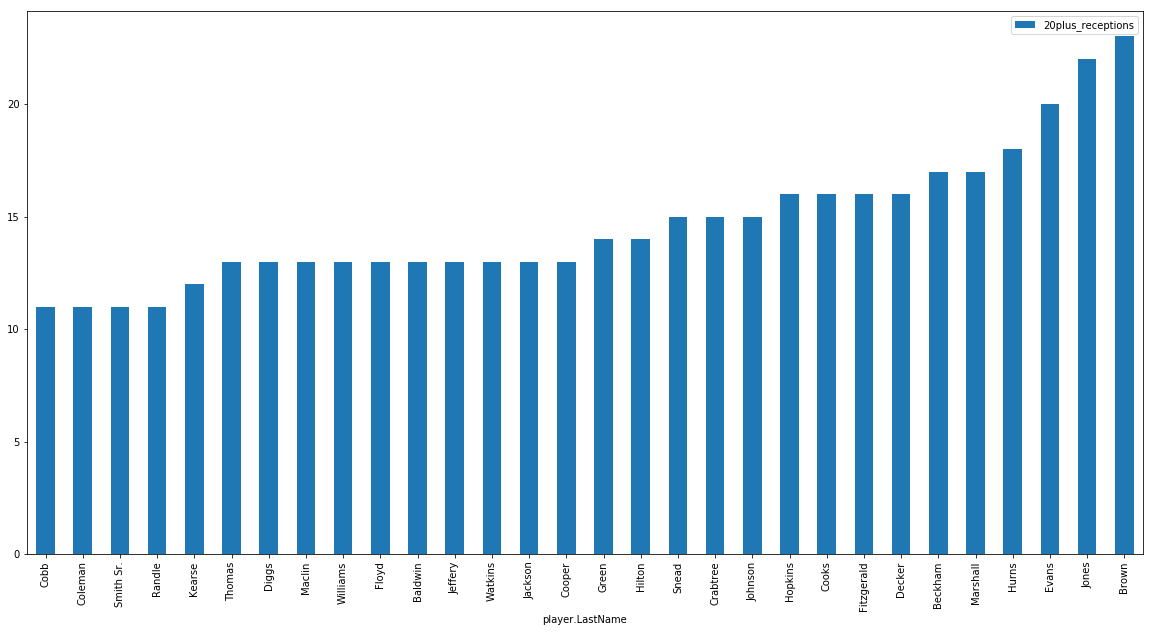

In [28]:
wr20plus = wr[['player.LastName','stats.Rec20Plus.#text']].copy()
wr20plus['20plus_receptions'] = pd.to_numeric(wr20plus['stats.Rec20Plus.#text'])
wr20plus.sort_values('20plus_receptions', inplace=True)
# Filter greater than 10 - 20plus yard receptions
wr20plus_greaterthan10 = wr20plus.loc[wr20plus['20plus_receptions'] > 10]
# Plot
wr20plus_greaterthan10.plot(x='player.LastName',figsize=(20,10), kind='bar')

## Wide Recievers Convert Stats to Numeric Cols

In [93]:
# Find all the reception columns
rec_cols = []
for col in wr.columns:
    if col[:9] == 'stats.Rec' and col[-5:] == '#text':
        rec_cols.append(col)

# Create wr_stats
wr_stats = wr[['player.FirstName','player.LastName','player.Position']+rec_cols].copy()
wr_stats = wr_stats.set_index(wr_stats['player.FirstName'] + ' ' + wr_stats['player.LastName'])

# Change to numeric and delete non-numeric columns
for col in rec_cols:
    wr_stats[col[:-6]] = pd.to_numeric(wr_stats[col])
    wr_stats.drop(col, axis=1, inplace=True)
    
# Filter to at least 500 reception yards
wr_stats_atleast500 = wr_stats.loc[wr_stats['stats.RecYards'] > 500]

## Cluster Analysis of WRs

In [94]:
km = KMeans(n_clusters=5)
km.fit(wr_stats_atleast500.select_dtypes([np.number]))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [97]:
wr_stats_atleast500['cluster'] = km.labels_

/Users/robmulla/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [74]:
# Show the top recievers and their clusters
wr_stats_atleast500.sort_values('stats.Receptions',
                                ascending=False).head()

,player.FirstName,player.LastName,player.Position,stats.Rec20Plus,stats.Rec40Plus,stats.RecAverage,stats.RecFumbles,stats.RecLng,stats.RecTD,stats.RecYards,stats.Receptions,cluster
Julio Jones,Julio,Jones,WR,22,5,13.8,0,70,8,1871,136,0
Antonio Brown,Antonio,Brown,WR,23,8,13.6,0,59,10,1843,136,0
DeAndre Hopkins,DeAndre,Hopkins,WR,16,3,13.7,0,61,11,1522,111,4
Jarvis Landry,Jarvis,Landry,WR,8,3,10.5,0,50,4,1157,110,2
Brandon Marshall,Brandon,Marshall,WR,17,5,13.9,0,69,14,1513,109,4


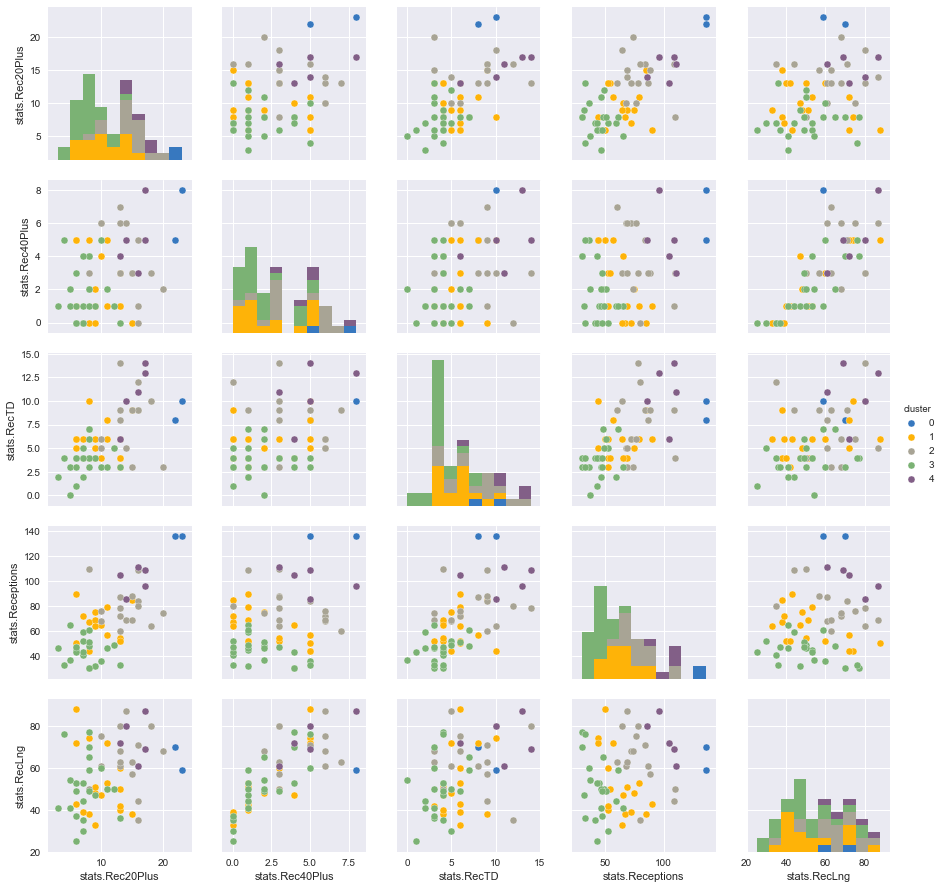

In [88]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
pal = sns.xkcd_palette(colors)
sns.pairplot(wr_stats_atleast500,
             hue='cluster', 
             vars=['stats.Rec20Plus',
                   'stats.Rec40Plus',
                   'stats.RecTD',
                   'stats.Receptions',
                   'stats.RecLng'],
                    palette=pal)

# Cluster Analysis of WRs Different Season

/Users/robmulla/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


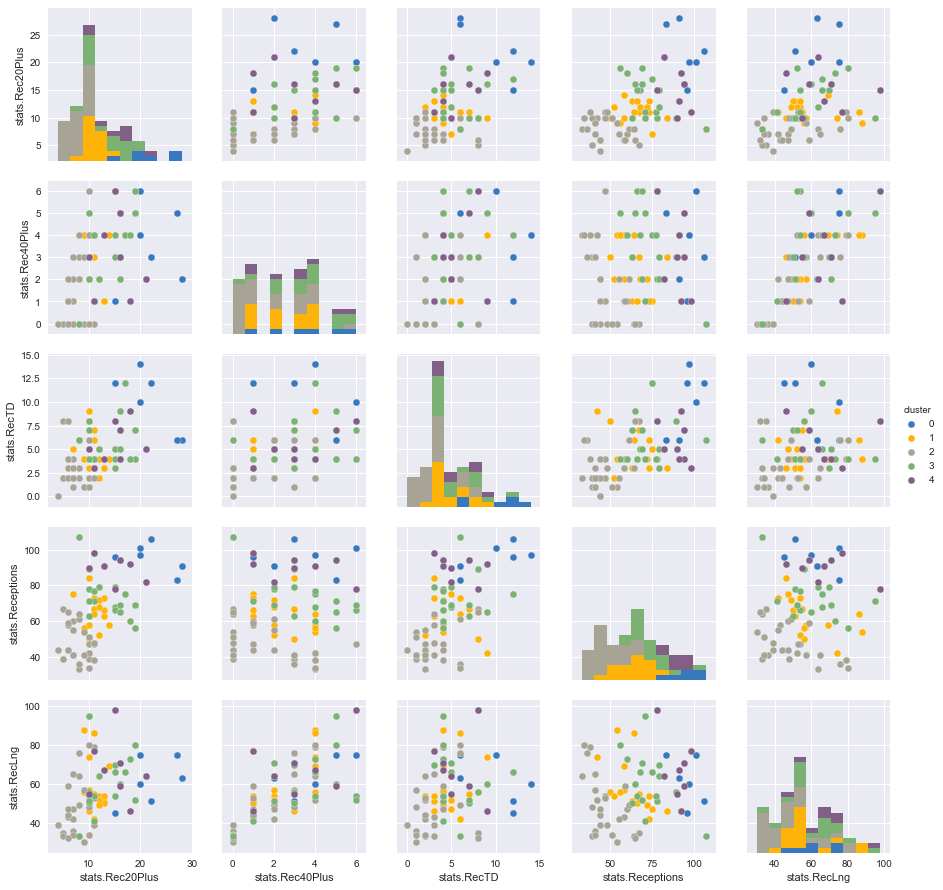

In [98]:
nfl = msf.msf_get_data(league='nfl',
                       season='2016-2017-regular',
                       feed='cumulative_player_stats',
                       format='json')

df = json_normalize(nfl['cumulativeplayerstats']['playerstatsentry'])
df2 = df.loc[df.fillna('9999.9')['stats.Fg1_19Pct.#text'].apply(float) < 9999]
wr = df.loc[(df['player.Position'] == 'WR')]

# Find all the reception columns
rec_cols = []
for col in wr.columns:
    if col[:9] == 'stats.Rec' and col[-5:] == '#text':
        rec_cols.append(col)

# Create wr_stats
wr_stats = wr[['player.FirstName','player.LastName','player.Position']+rec_cols].copy()
wr_stats = wr_stats.set_index(wr_stats['player.FirstName'] + ' ' + wr_stats['player.LastName'])

# Change to numeric and delete non-numeric columns
for col in rec_cols:
    wr_stats[col[:-6]] = pd.to_numeric(wr_stats[col])
    wr_stats.drop(col, axis=1, inplace=True)
    
# Filter to at least 500 reception yards
wr_stats_atleast500 = wr_stats.loc[wr_stats['stats.RecYards'] > 500]

km = KMeans(n_clusters=5)
km.fit(wr_stats_atleast500.select_dtypes([np.number]))
wr_stats_atleast500['cluster'] = km.labels_
# Pair plot
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
pal = sns.xkcd_palette(colors)
sns.pairplot(wr_stats_atleast500,
             hue='cluster', 
             vars=['stats.Rec20Plus',
                   'stats.Rec40Plus',
                   'stats.RecTD',
                   'stats.Receptions',
                   'stats.RecLng'],
                    palette=pal)

In [103]:
wr_stats_atleast500.sort_values('stats.Receptions',
                                ascending=False).head()

,player.FirstName,player.LastName,player.Position,stats.Rec20Plus,stats.Rec40Plus,stats.RecAverage,stats.RecFumbles,stats.RecLng,stats.RecTD,stats.RecYards,stats.Receptions,cluster
Larry Fitzgerald,Larry,Fitzgerald,WR,8,0,9.6,0,33,6,1025,107,3
Antonio Brown,Antonio,Brown,WR,22,3,12.1,0,51,12,1284,106,0
Odell Beckham,Odell,Beckham,WR,20,6,13.5,0,75,10,1367,101,0
Julian Edelman,Julian,Edelman,WR,11,1,11.3,0,77,3,1106,98,4
Jordy Nelson,Jordy,Nelson,WR,20,4,13.0,0,60,14,1257,97,0


In [101]:
wr_stats_atleast500.loc[wr_stats_atleast500['cluster'] == 1]

,player.FirstName,player.LastName,player.Position,stats.Rec20Plus,stats.Rec40Plus,stats.RecAverage,stats.RecFumbles,stats.RecLng,stats.RecTD,stats.RecYards,stats.Receptions,cluster
Cole Beasley,Cole,Beasley,WR,7,1,11.2,0,47,5,844,75,1
Dez Bryant,Dez,Bryant,WR,10,3,16.0,0,56,8,802,50,1
Jamison Crowder,Jamison,Crowder,WR,11,3,12.8,0,55,7,854,67,1
Stefon Diggs,Stefon,Diggs,WR,10,3,10.8,0,46,3,903,84,1
Quincy Enunwa,Quincy,Enunwa,WR,14,4,14.8,0,69,4,857,58,1
Ted Ginn,Ted,Ginn,WR,9,4,13.9,0,88,4,752,54,1
Dontrelle Inman,Dontrelle,Inman,WR,10,2,14.0,0,57,4,810,58,1
Alshon Jeffery,Alshon,Jeffery,WR,12,2,15.8,0,54,2,821,52,1
Brandon LaFell,Brandon,LaFell,WR,11,4,13.5,0,86,6,862,64,1
Marqise Lee,Marqise,Lee,WR,13,1,13.5,0,51,3,851,63,1


In [132]:
wr_stats_atleast500['fullname'] = wr_stats_atleast500.index

/Users/robmulla/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Bokeh Plots

In [111]:
from bokeh.io import output_notebook
output_notebook()

from bokeh.io import show
from bokeh.plotting import figure

from bokeh.models import HoverTool

Loading BokehJS ...

In [156]:
wr_stats_atleast500.head()

,player.FirstName,player.LastName,player.Position,stats.Rec20Plus,stats.Rec40Plus,stats.RecAverage,stats.RecFumbles,stats.RecLng,stats.RecTD,stats.RecYards,stats.Receptions,cluster,fullname
Davante Adams,Davante,Adams,WR,17,4,13.6,0,66,12,1017,75,3,Davante Adams
Robby Anderson,Robby,Anderson,WR,10,4,14.0,0,52,2,587,42,2,Robby Anderson
Tavon Austin,Tavon,Austin,WR,6,1,8.8,0,43,3,509,58,2,Tavon Austin
Doug Baldwin,Doug,Baldwin,WR,16,5,12.0,0,59,7,1129,94,4,Doug Baldwin
Cole Beasley,Cole,Beasley,WR,7,1,11.2,0,47,5,844,75,1,Cole Beasley


In [188]:
colormap = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'black' }
colors = [colormap[x] for x in wr_stats_atleast500['cluster']]

hover = HoverTool(tooltips=[("Player: ", "@fullname"),])
p = figure(tools = [hover], plot_width=800, plot_height=300)
p.circle(x='stats.Receptions',
         y='stats.RecAverage',
        color=colors,
        size=15,
        source=wr_stats_atleast500,
        )
p.xaxis.axis_label = 'Receptions'
p.yaxis.axis_label = 'Average Reception (Yards)'
show(p)

/Users/robmulla/anaconda2/envs/py36/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Users/robmulla/anaconda2/envs/py36/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
